In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import matplotlib

import cv2

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from PIL import Image

from skimage.morphology import skeletonize, thin
from skimage.util import invert
from skimage import measure
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt
import seaborn as sns
sns.reset_orig()

from skimage import restoration

from skimage import exposure
from skimage.filters import gaussian

from scipy import ndimage

from time import time

from skimage.color import rgb2gray

from skimage.color import rgb2hsv
from skimage.color import hsv2rgb



from skimage.filters.rank import entropy
import scipy

from skimage import data, filters
import scipy

import networkx as nx
from scipy import interpolate

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import glob

from skimage.morphology import disk
from skimage import io

from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
parade = np.asarray(Image.open('/Users/spencerlab/Downloads/RGBParadeImagesSpencerLab/RedChannelParadeRGBSequence1103.tif'))


mask= np.logical_and((parade[:,:,1]==parade[:,:,0]), (parade[:,:,2]==parade[:,:,0]))
parade2 = parade.copy()

mask=mask==0
parade2[:,:,0] = mask*parade[:,:,0]
parade2[:,:,1] = mask*parade[:,:,1]
parade2[:,:,2] = mask*parade[:,:,2]
parade2[:,:,3] = mask*parade[:,:,3]

In [3]:
stack = io.imread("/Users/spencerlab/Desktop/final_files/Day_3/#2/Stack_day_3_#2.tif")

In [4]:
SLICE = 150

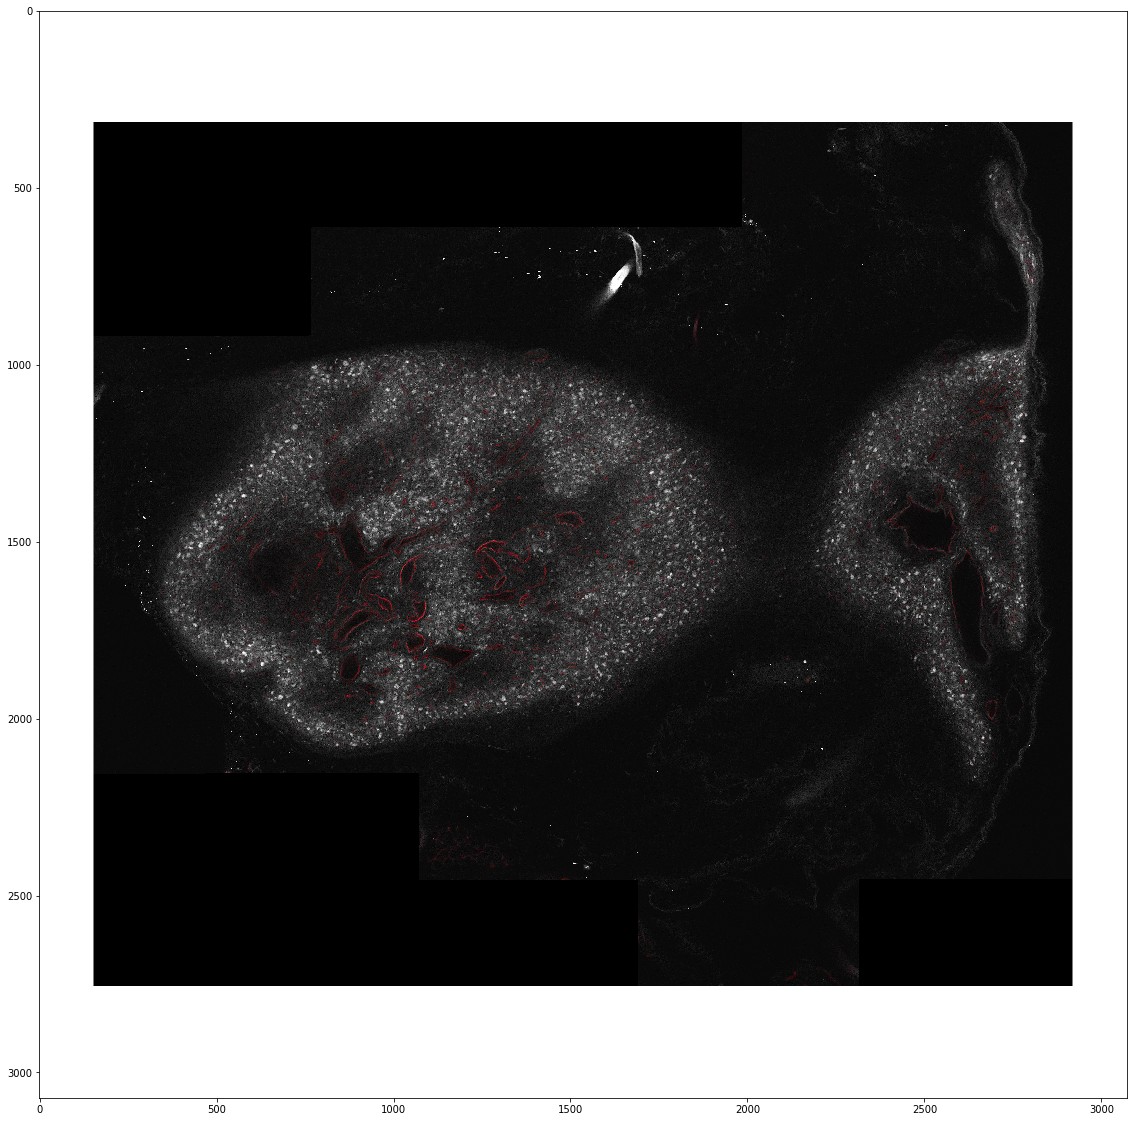

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(parade)

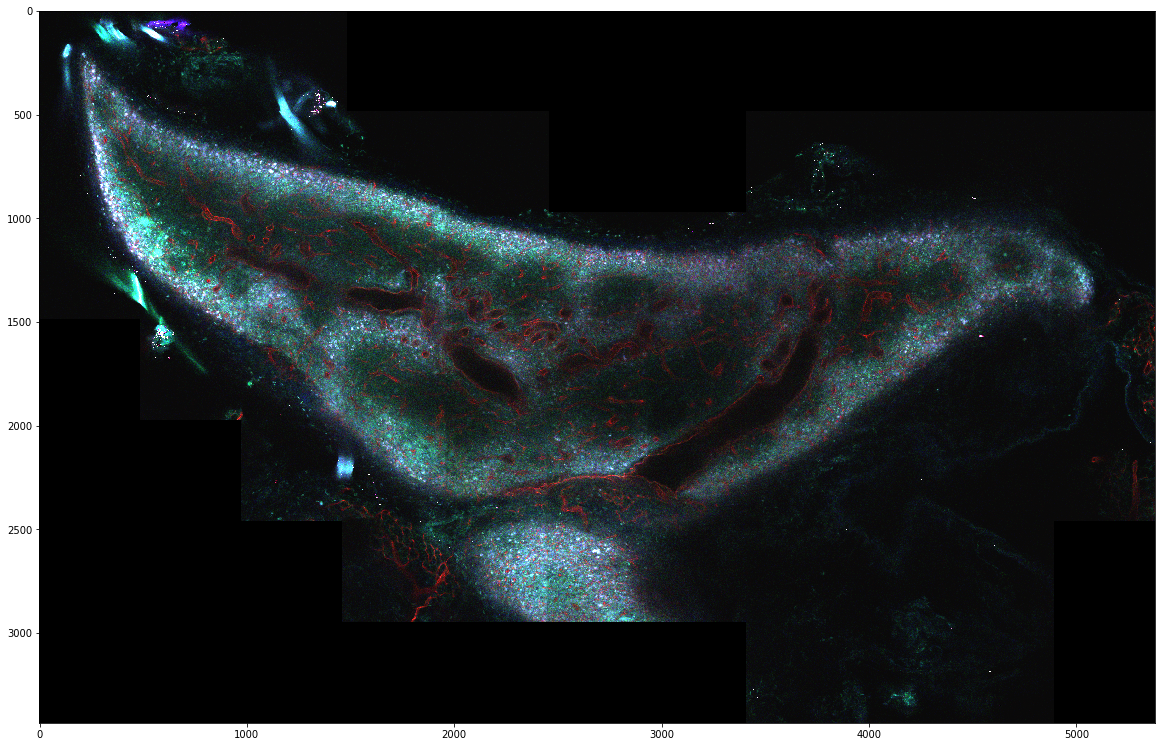

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(stack[SLICE])

In [7]:
def hsv_constraints(image):
    
    hsv_img = rgb2hsv(image)
    
    r_flat = (image[:,:,0]).flatten()
    g_flat = (image[:,:,1]).flatten()
    b_flat = (image[:,:,2]).flatten()



    h_flat = (hsv_img[:,:,0]).flatten()
    s_flat = (hsv_img[:,:,1]).flatten()
    v_flat = (hsv_img[:,:,2]).flatten()
    
    
    
    h_flat_2 = []
    s_flat_2 = []
    v_flat_2 = []
    
    
    for i in range(len(r_flat)):
        if r_flat[i]!=0 or g_flat[i]!=0 or b_flat[i]!=0:
            h_flat_2.append(h_flat[i])
            s_flat_2.append(s_flat[i])
            v_flat_2.append(v_flat[i])
    
    
    h_flat_2 = np.asarray(h_flat_2)

    
    h_unk = np.unique(h_flat_2)
    min_hue = h_unk[0]
    max_hue = h_unk[-1]


    diff = max_hue-min_hue
    
    
    
    
    
    
    
    neg = (h_flat_2-1)*(h_flat_2>=0.5)
    pos = h_flat_2*(h_flat_2<0.5)
    rang = neg+pos
    unk_rang = np.unique(rang)
    
    min_hue_2 = unk_rang[0]
    max_hue_2 = unk_rang[-1]
    
    
    if diff> max_hue_2-min_hue_2:
        min_hue = min_hue_2
        max_hue = max_hue_2
    
    
    
    
    
    
    
    
    unk_Sat = np.unique(s_flat_2)
    unk_Val = np.unique(v_flat_2)
    
    
    min_sat = unk_Sat[0]
    max_sat = unk_Sat[-1]
    
    min_val = unk_Val[0]
    max_val = unk_Val[-1]
    
    return min_hue, max_hue, min_sat, max_sat, min_val, max_val

In [8]:
def keep_inrange(hsv_img, min_h, max_h):
    
    
    neg = (hsv_img[:,:,0]-1)*(hsv_img[:,:,0]>=0.5)
    #neg=neg*(neg>=min_h)
    
    
    pos = hsv_img[:,:,0]*(hsv_img[:,:,0]<0.5)
    #pos = pos*(pos<=max_h)
    
    
    #ret = neg+pos
    
    ret_hsv = hsv_img.copy()
    
    ret_hsv[:,:,1] = hsv_img[:,:,1]*(neg>=min_h)*(pos<=max_h)
    
    return ret_hsv

In [9]:
def clean(inpt):
    ret = inpt.copy()
    for i in range(len(inpt)):
        for x in range(len(inpt[0])):
            if np.isnan(inpt[i,x]):
                ret[i,x]=0
            else:
                ret[i,x]=inpt[i,x]
        
    return ret

In [10]:
def denoise_repeat(image_stk, patch_size, patch_distance, h, n):
    ret = image_stk
    for i in range(n):
        ret=restoration.denoise_nl_means(ret, patch_size=patch_size, patch_distance=patch_distance, h=h)
        ret=clean(ret)
    return ret

In [11]:
def mix_filters(image, patch_size, patch_distance, h, n, canny_sigma, denoise_tresh):
    nlm = denoise_repeat(image[:,:,0], patch_size, patch_distance, h, n)
    
    edges = feature.canny(image[:,:,0], canny_sigma)
    
    
    mix_tresh = np.logical_or(edges,(nlm>denoise_tresh))
    
    return mix_tresh

In [12]:
def remove_specs(inpt, max_spec_size):
    ret = np.ones(inpt.shape)
    for i in range(len(inpt)):
        for x in range(len(inpt[0])):
            num = 0
            for n1 in range(-1,2):
                for n2 in range(-1,2):
                    try:
                        if inpt[i+n1, x+n2] ==1:
                            num=num+1
                    except:
                        cat = 0
            if num <=max_spec_size:
                ret[i, x] = 0
            else:
                ret[i, x] = inpt[i, x]
            
    return ret

In [13]:
def color_leave_filter(image, min_hue, max_hue, min_sat, max_sat, min_val, max_val):
    
    hsv_img = rgb2hsv(image) 
    
    kir = keep_inrange(hsv_img, min_hue, max_hue)
    
    kir2=kir.copy()
    kir2[:,:,1]=kir2[:,:,1]
    kir2[:,:,2]=kir2[:,:,2]*(kir2[:,:,1]>=min_sat)*(kir2[:,:,1]<=max_sat)*(kir2[:,:,2]>=min_val)*(kir2[:,:,2]<=max_val)
    

    return (np.round(hsv2rgb(kir2)*255).astype('uint8'))

In [14]:
mih, mah, mis, mas, miv, mav = hsv_constraints(parade2[:,:,:3])

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [15]:
[mih, mah, mis, mas, miv, mav]

[-0.06439393939393945,
 0.06047197640117993,
 0.004854368932038817,
 1.0,
 0.00784313725490196,
 1.0]

In [17]:
output_image = color_leave_filter(stack[SLICE], mih, mah, mis, mas, miv, mav)

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]


In [18]:
np.unique(output_image)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

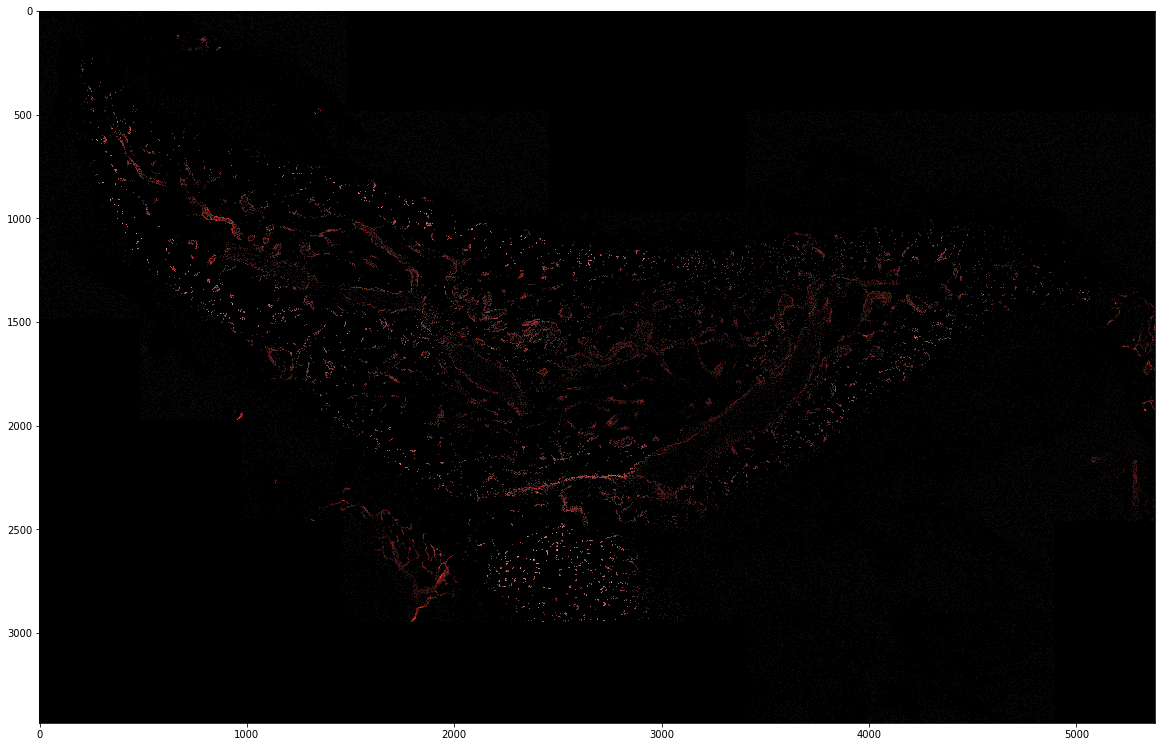

In [24]:
plt.figure(figsize=(20,20))


Image.fromarray(output_image).show()
Image.fromarray(stack[SLICE]).show()
plt.imshow(output_image)

In [22]:
Image.fromarray(output_image).save('Day3_parade.tif')

In [25]:
mfilt = mix_filters(image=output_image, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)



/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


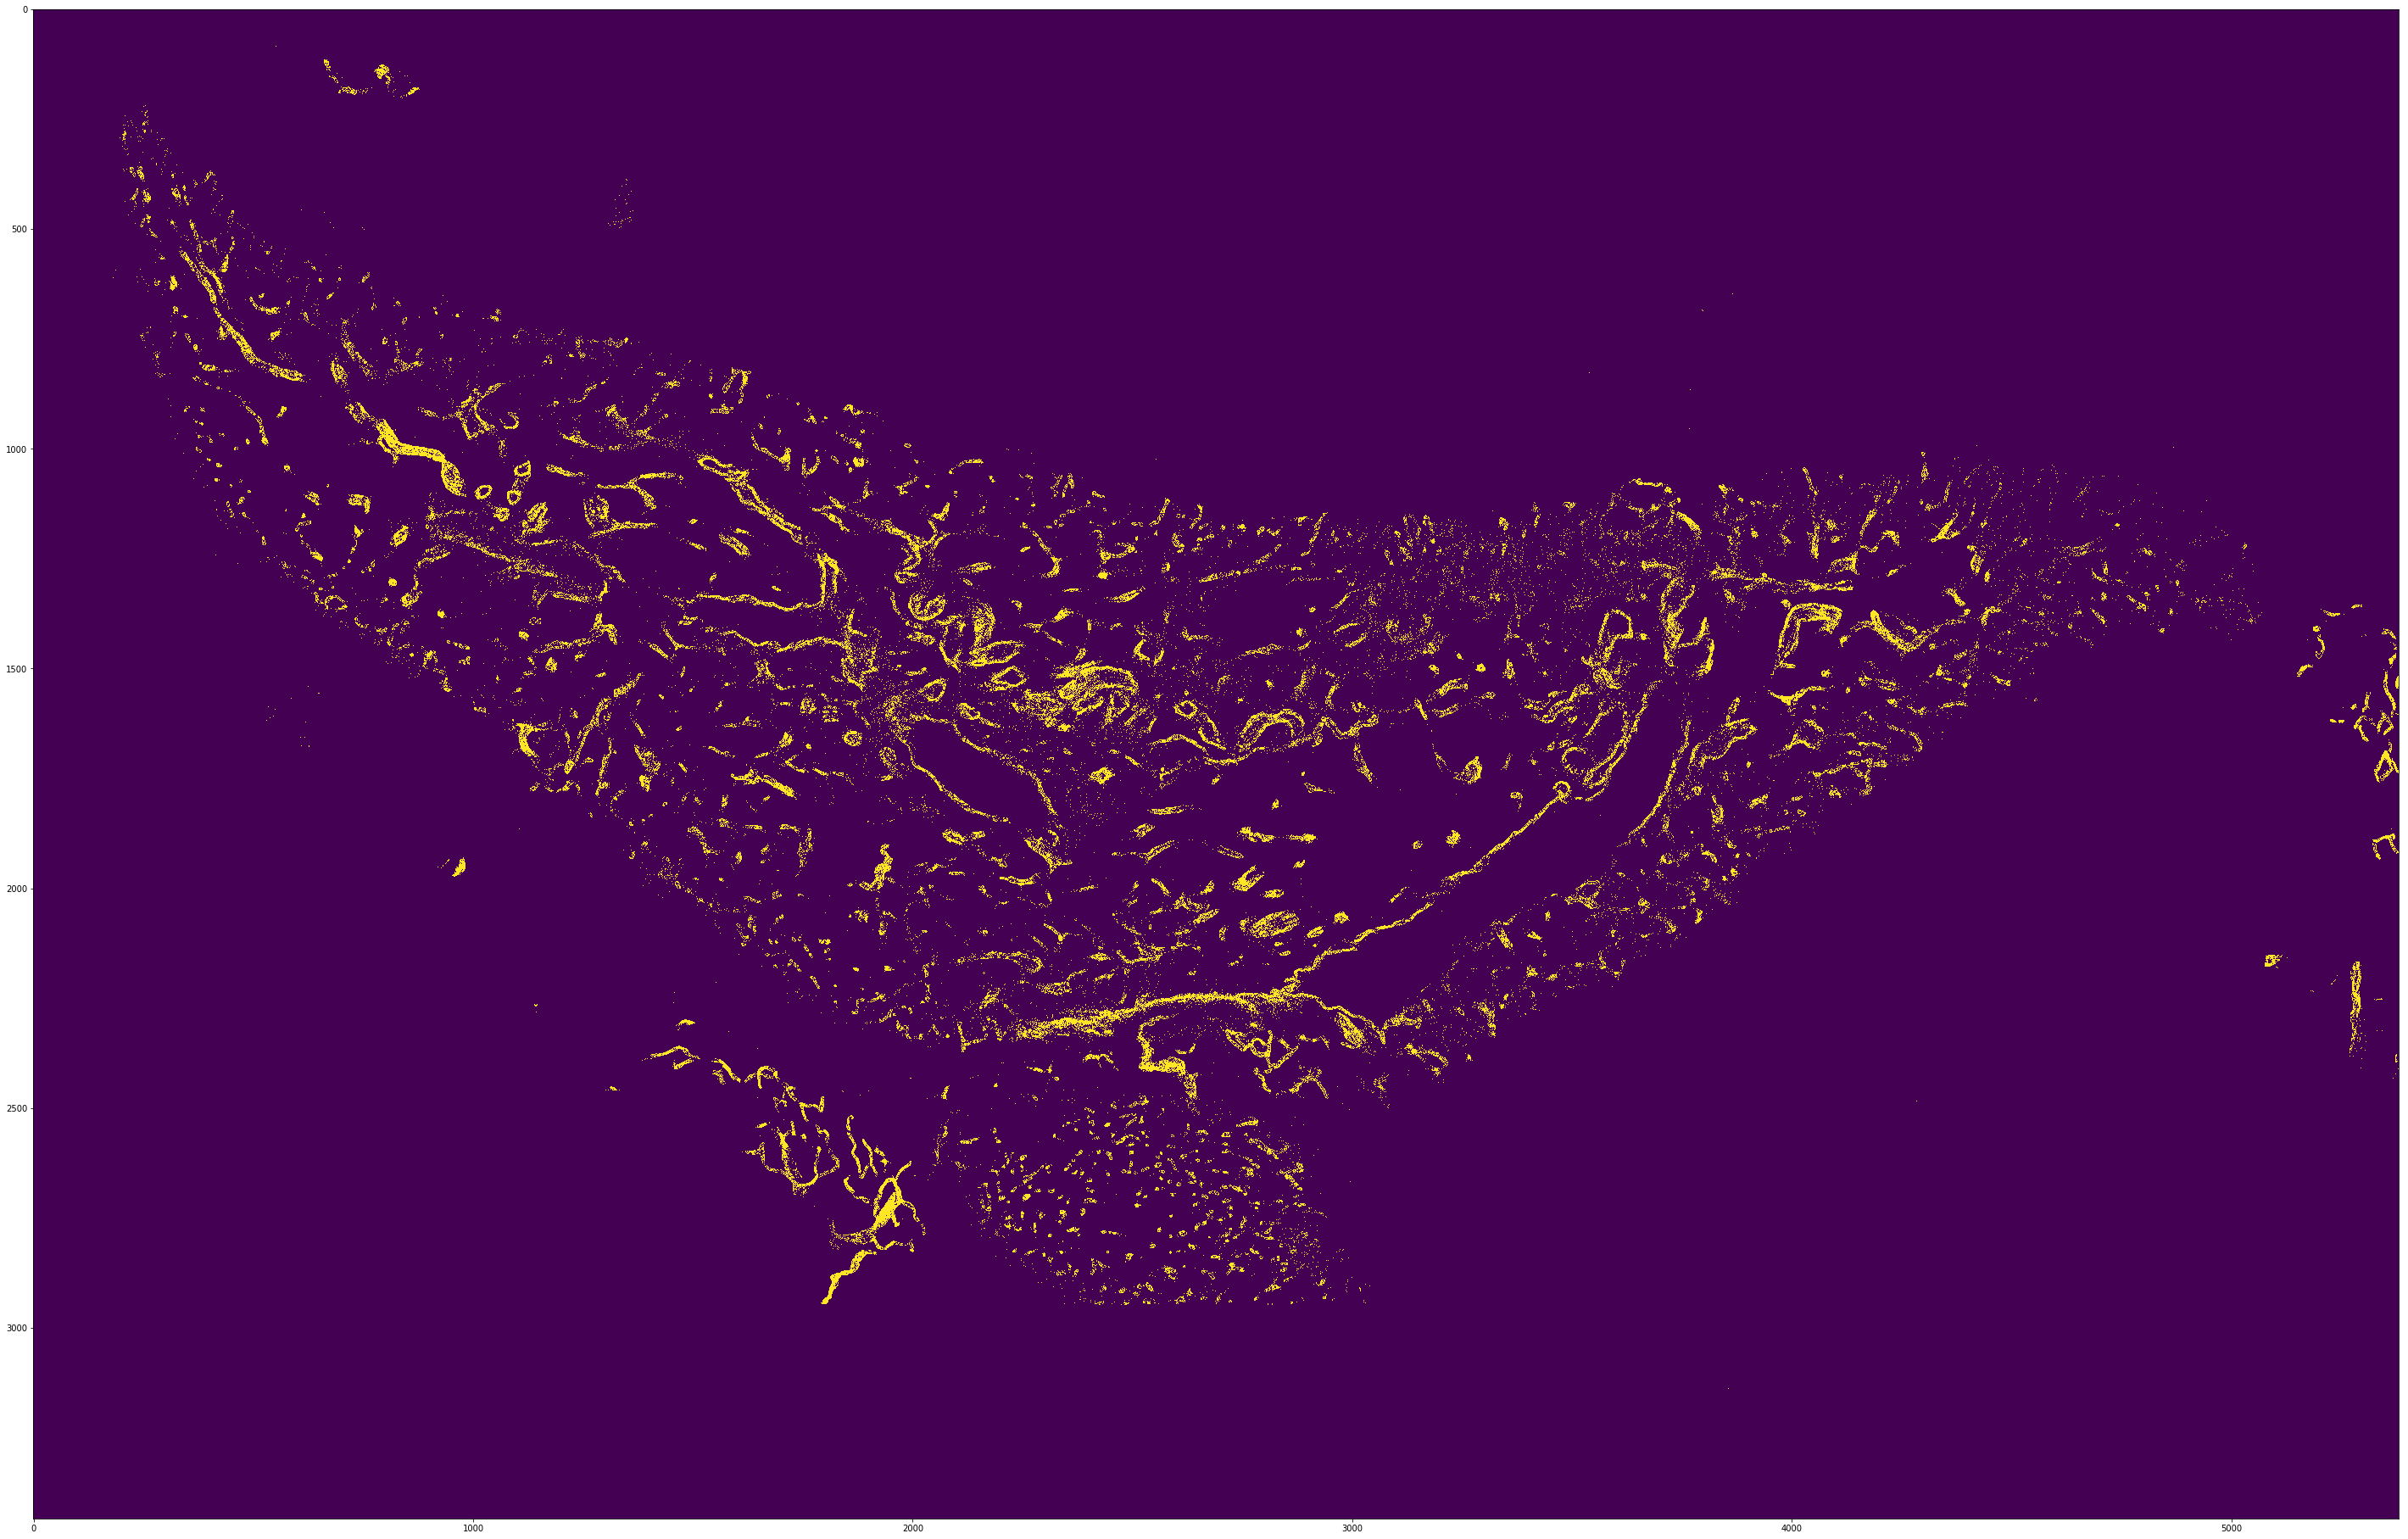

In [34]:
#plt.figure(figsize=(50,50))

#Image.fromarray((mfilt*255).astype('uint8')).show()
#plt.imshow(mfilt)

In [38]:
square = mfilt!=0

eroded_square = ndimage.binary_erosion(square)
reconstruction = ndimage.binary_propagation(eroded_square, mask=square)
reconstruction2 = ndimage.binary_closing(reconstruction)


Image.fromarray(stack[SLICE]).show()
Image.fromarray(((reconstruction2!=0)*255).astype('uint8')).show()

In [39]:
for i in range(len(stack)):
    clv = color_leave_filter(stack[i], mih, mah, mis, mas, miv, mav)
    mfilt = mix_filters(image=clv, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)

    square = mfilt!=0
    
    eroded_square = ndimage.binary_erosion(square)
    reconstruction = ndimage.binary_propagation(eroded_square, mask=square)
    reconstruction2 = ndimage.binary_closing(reconstruction)
    
    print(i)
    
    Image.fromarray(((reconstruction2!=0)*255).astype('uint8')).save('red5/'+str(i)+'.tif')

/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default

0


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


1


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


2


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


3


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


4


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


5


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


6


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


7


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


8


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


9


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


10


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


11


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


12


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


13


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


14


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


15


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


16


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


17


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


18


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


19


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


20


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


21


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


22


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


23


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


24


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


25


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


26


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


27


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


28


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


29


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


30


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


31


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


32


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


33


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


34


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


35


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


36


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


37


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


38


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


39


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


40


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


41


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


42


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


43


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


44


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


45


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


46


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


47


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


48


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


49


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


50


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


51


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


52


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


53


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


54


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


55


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


56


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


57


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


58


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


59


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


60


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


61


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


62


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


63


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


64


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


65


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


66


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


67


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


68


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


69


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


70


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


71


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


72


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


73


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


74


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


75


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


76


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


77


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


78


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


79


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


80


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


81


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


82


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


83


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


84


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


85


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


86


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


87


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


88


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


89


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


90


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


91


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


92


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


93


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


94


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


95


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


96


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


97


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


98


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


99


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


100


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


101


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


102


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


103


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


104


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


105


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


106


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


107


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


108


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


109


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


110


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


111


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


112


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


113


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


114


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


115


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


116


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


117


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


118


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


119


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


120


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


121


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


122


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


123


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


124


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


125


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


126


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


127


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


128


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


129


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


130


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


131


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


132


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


133


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


134


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


135


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


136


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


137


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


138


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


139


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


140


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


141


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


142


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


143


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


144


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


145


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


146


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


147


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


148


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


149


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


150


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


151


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


152


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


153


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


154


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


155


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


156


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


157


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


158


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


159


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


160


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


161


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


162


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


163


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


164


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


165


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


166


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


167


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


168


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


169


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


170


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


171


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


172


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


173


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


174


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


175


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


176


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


177


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


178


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


179


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


180


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


181


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


182


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


183


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


184


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


185


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


186


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


187


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


188


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


189


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


190


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


191


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


192


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


193


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


194


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


195


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


196


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


197


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


198


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


199


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


200


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


201


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


202


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


203


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


204


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


205


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


206


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


207


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


208


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


209


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


210


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


211


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


212


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


213


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


214


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


215


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


216


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


217


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


218


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


219


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


220


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


221


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


222


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


223


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


224


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


225


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


226


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


227


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


228


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


229


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


230


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


231


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


232


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


233


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


234


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


235


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


236


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


237


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


238


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


239


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


240


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


241


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


242


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


243


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


244


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


245


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


246


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


247


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


248


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


249


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


250


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


251


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


252


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


253


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


254


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


255


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


256


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


257


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


258


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


259


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


260


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


261


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


262


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


263


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


264


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


265


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


266


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


267


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


268


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


269


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


270


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


271


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


272


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


273


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


274


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


275


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


276


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


277


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


278


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


279


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


280


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


281


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


282


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


283


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


284


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


285


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


286


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


287


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


288


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


289


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


290


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


291


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


292


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


293


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


294


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


295


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


296


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


297


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


298


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


299


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


300


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


301


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


302


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


303


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


304


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


305


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


306


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


307


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


308


In [ ]:
#file name above

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(closed)

In [ ]:
np.unique(closed*255)

In [ ]:
Image.fromarray( (closed*255).astype('uint8') ).save('3_D_Vessel_seg/'+str(150)+'.tif')

In [26]:

for i in range(0, 822):
    print(i)
    
    output_image = color_leave_filter(stack[i], mih, mah, mis, mas, miv, mav)
    
    mfilt = mix_filters(image=output_image, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)

    mfilt_DN = remove_specs(mfilt, 2)
    
    closed= scipy.ndimage.binary_closing(mfilt_DN)
    
    Image.fromarray( (closed*255).astype('uint8') ).save('blood/'+str(i)+'.tif')

0


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


1


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


2


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


KeyboardInterrupt: 

In [32]:
def x(r1,r2):
    for i in range(r1, r2):
        print(i)
    
        output_image = color_leave_filter(stack[i], mih, mah, mis, mas, miv, mav)
    
        mfilt = mix_filters(image=output_image, patch_size=450, patch_distance=9, h=0.1, n=2, canny_sigma=2, denoise_tresh=50)

        mfilt_DN = remove_specs(mfilt, 2)
    
        closed= scipy.ndimage.binary_closing(mfilt_DN)
            
        Image.fromarray( (closed*255).astype('uint8') ).save('blood/'+str(i)+'.tif')

In [ ]:

    Image.fromarray( (closed*255).astype('uint8') ).save('3_D_Vessel_seg/'+str(i)+'.tif')

In [28]:
import threading

In [33]:
if __name__ == "__main__": 
    # creating thread 
    t1 = threading.Thread(target=x, args=(0,150+1,)) 
    t2 = threading.Thread(target=x, args=(150,300+1,)) 
    t3 = threading.Thread(target=x, args=(300,450+1,) )
    t4 = threading.Thread(target=x, args=(450,600+1,))
    t5 = threading.Thread(target=x, args=(600,822,))
    # starting thread 1 
    t1.start() 
    t2.start() 
    t3.start() 
    t4.start()
    t5.start()

    # wait until thread 1 is completely executed 
    t1.join() 
    t2.join() 
    t3.join() 
    t4.join() 
    t5.join() 
    # both threads completely executed 
    print("Done!") 
    

0
150
300
450600



/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

1
151
451
301
601


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

152
2


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


452


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


602
302


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

153
3


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


453


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


303
603


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

154


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


4
454
604
304


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

155


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


5
455


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


305
605


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

156


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


6


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


456
306
606


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

157


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


7


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


457
307


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


607


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

158


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


8


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


458
308


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


608


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

159


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


9


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


459
309


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


609


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

160


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


10


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


460


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


310


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


610


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

161


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


11


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


461
311


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


611


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

162


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


12


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


462


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


312
612


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

163


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


13


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


463


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


313


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


613


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

164


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


14


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


464


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


614
314


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

165


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


15


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


465


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


315
615


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

166


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


16


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


466


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


316
616


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

167


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


17


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


467


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


317
617


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

168


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


18


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


468


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


318
618


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

169


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


19


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


469


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


619
319


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

170


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


20


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


470


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


620
320


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

171


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


21


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


471


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


621
321


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

172


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


22


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


472


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


622
322


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

173


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


23


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


473


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


623
323


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

174


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


24


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


474


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


624
324


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

175


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


25


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


475


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


625
325


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

176


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


26


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


476


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


626
326


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

177


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


27


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


477


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


327
627


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

178


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


28


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


478


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


628


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


328


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


179


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


29


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


479


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


629
329


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


180


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


30


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


480


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


330
630


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


181


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


31


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


481


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


631
331


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


182


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


32


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


482


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


632
332


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


183


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


33


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


483


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


633
333


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


184


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


34


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


484


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


634
334


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


185


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


35


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


485


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


635


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


335


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


186


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


36


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


486


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


636
336


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


187


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


37


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


487


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


637


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


337


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


188


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


38


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


488


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


638
338


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


189


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


39


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


489


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


339
639


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


190


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


40


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


490


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


340
640


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


191


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


41


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


491


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


341
641


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


192


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


42


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


492


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


642
342


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


193


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


43


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


493


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


643
343


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


194


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


44


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


494


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


644
344


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


195


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


45


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


495


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


645
345


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


196


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


46


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


496


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


346
646


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


197


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


47


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


497


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


347
647


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


198


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


48


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


498


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


348
648


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


199


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


49


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


499


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


349
649


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


200


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


50


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


500


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


650
350


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


201


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


51


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


501


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


651
351


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


202


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


52


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


502


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


652
352


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


203


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


53


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


503


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


653
353


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


204


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


54


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


504


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


654


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


354


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


205


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


55


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


505


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


655


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


355


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


206


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


56


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


506


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


656


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


356


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


207


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


57


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


507


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


657


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


357


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


208


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


58


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


508


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


658


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


358


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


209


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


59


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


509


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


659


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


359


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


210


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


60


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


510


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


660


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


360


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


211


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


61


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


511


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


661
361


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


212


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


62


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


512


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


662
362


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


213


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


63


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


513


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


663
363


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


214


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


64


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


514


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


664
364


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


215


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


65


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


515


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


665
365


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


216


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


66


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


516


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


666
366


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


217


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


67


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


517


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


667
367


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


218


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


68


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


518


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


668
368


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


219


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


69


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


519


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


369
669


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


220


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


70


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


520


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


370
670


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


221


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


71


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


521


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


371
671


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


222


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


72


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


522


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


372
672


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


223


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


73


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


523


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


373
673


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


224


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


74


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


524


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


374
674


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


225


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


75


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


525


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


675
375


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


226


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


76


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


526


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


676
376


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


227


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


77


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


527


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


677
377


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


228


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


78


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


528


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


378
678


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


229


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


79


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


529


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


379
679


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


230


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


80


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


530


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


380
680


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


231


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


81


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


531


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


381
681


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


232


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


82


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


532


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


382


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


682


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


233


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


83


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


533


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


383
683


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


234


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


84


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


534


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


384
684


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


235


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


85


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


535


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


385
685


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


236


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


86


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


536


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


386
686


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


237


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


87


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


537


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


387
687


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


238


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


88


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


538


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


388
688


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


239


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


89


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


539


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


689
389


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


240


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


90


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


540


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


390
690


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


241


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


91


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


541


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


691
391


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


242


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


92


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


542


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


692


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


392


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


243


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


93


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


543


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


693
393


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


244


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


94


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


544


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


694
394


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


245


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


95


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


545


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


695
395


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


246


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


96


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


546


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


696
396


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


247


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


97


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


547


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


697
397


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


248


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


98


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


548


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


698


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


398


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


249


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


99


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


549


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


699
399


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


250


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


100


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


550


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


700
400


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


251


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


101


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


551


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


701
401


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


252


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


102


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


552


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


402
702


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


253


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


103


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


553


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


403
703


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


254


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


104


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


554


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


704
404


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


255


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


105


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


555


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


405
705


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


256


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


106


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


556


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


706
406


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


257


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


107


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


557


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


707
407


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


258


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


108


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


558


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


408
708


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


259


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


109


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


559


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


409
709


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


260


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


110


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


560


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


410
710


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


261


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


111


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


561


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


711
411


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


262


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


112


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


562


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


412
712


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


263


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


113


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


563


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


413
713


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


264


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


114


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


564


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


714
414


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


265


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


115


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


565


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


715
415


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


266


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


116


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


566


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


716
416


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


267


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


117


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


567


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


417
717


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


268


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


118


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


568


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


418
718


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


269


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


119


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


569


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


719
419


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


270


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


120


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


570


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


420
720


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


271


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


121


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


571


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


421


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


721


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


272


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


122


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


572


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


422


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


722


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


273


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


123


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


573


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


423
723


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


274


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


124


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


574


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


424
724


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


275


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


125


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


575


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


425
725


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


276


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


126


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


576


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


426
726


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


277


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


127


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


577


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


427
727


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


278


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


128


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


578


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


428
728


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


279


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


129


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


579


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


429
729


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


280


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


130


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


580


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


430
730


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


281


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


131


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


581


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


431
731


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


282


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


132


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


582


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


432
732


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


283


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


133


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


583


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


733
433


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


284


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


134


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


584


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


734
434


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


285


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


135


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


585


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


735
435


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


286


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


136


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


586


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


736
436


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


287


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


137


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


587


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


437
737


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


288


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


138


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


588


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


438


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


738


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


289


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


139


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


589


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


439


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


739


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


290


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


140


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


590


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


440


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


740


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


291


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


141


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


591


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


441
741


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


292


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


142


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


592


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


442
742


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


293


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


143


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


593


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


443
743


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


294


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


144


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


594


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


444
744


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


295


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


145


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


595


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


445
745


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


296


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


146


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


596


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


446
746


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


297


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


147


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


597


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


447
747


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


298


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


148


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


598


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


448
748


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


299


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


149


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


599


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


749
449


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


300


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


150


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/an

600


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


750
450


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


751


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


752


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


753


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


754


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


755


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


756


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


757


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


758


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


759


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


760


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


761


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


762


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


763


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


764


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


765


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


766


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


767


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


768


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


769


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


770


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


771


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


772


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


773


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


774


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


775


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


776


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


777


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


778


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


779


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


780


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


781


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


782


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


783


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


784


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


785


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


786


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


787


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


788


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


789


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


790


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


791


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


792


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


793


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


794


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


795


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


796


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


797


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


798


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


799


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


800


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


801


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


802


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


803


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


804


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


805


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


806


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


807


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


808


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


809


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


810


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


811


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


812


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


813


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


814


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


815


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


816


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


817


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


818


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


819


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


820


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


821


/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')
/Users/spencerlab/anaconda3/lib/python3.7/site-packages/skimage/restoration/non_local_means.py:132: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


Done!
